## Threshold and Subject-level Accuracy Analysis on RNAseq data
### Authors: D. Tolosa, P. Joshi, R. Banda, B. Ziemann, Debajyoti Debnath

The main objective of the notebook is to simulate the variation for a given subject at different levels of relative standard deviation (RSD) of Transcripts Per Million (TPM) and then to demonstrate how the score varies. 

We have three main outputs from the notebook. <br>
Output 1: Scatter plot showing the simulated classifier scores vs the original classifier scores for all subjects. <br>
Output 2: File containing the subject-wise accuracy by calculating number of simulations that fall in FP and FN for a subject at a given threshold for further analysis.<br>
Output 3: File containing the False Positives, False Negatives, True Positives and True Negatives across 243 subjects at a given %RSD for further analysis.<br>
Output 4: v-plot od classifier scores vs accuracies (agreement)<br>

**_This project was developed at The Data Mine, Purdue University, in partnership with Molecular Stethoscope._**

In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent.resolve()))

In [2]:
import pandas as pd
import numpy as np
from src.classifier import (
    z_score,
)
from src.threshold import plot_uncertainty_at_threshold, plot_v_plot

In [3]:

### Reding csv file containing 243 subjects and their raw TPM counts across 1059 genes
### Source of data
raw_data = pd.read_excel(
    "../../raw_data/ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet_name=1
)
# setting index row name to the gene id
raw_data = raw_data.set_index("gene_id")

In [4]:
num_patients = 243

#### Step 1: Data prep

In [5]:
# Filtering out rows: discarding the ERCC rows, ERCC is a control protocol for validation of RNA sequencing
patients_df = raw_data[~raw_data.loc[:, "Coeff"].isnull()]

# We store the coefficients(betas) of the linear classifier in an array.
coefficients = np.nan_to_num(np.array(patients_df.loc[:, "Coeff"]))

# Filtering out columns with patient data
patients_df = patients_df.filter(regex=r"^\d+")

In [6]:
# group columns by patient id
grouped_cols = patients_df.columns.str.split("-").str[0]

# group columns by patient id and r1/r2 suffixes
grouped = patients_df.groupby(grouped_cols, axis=1)

# apply the mean function to the r1 and r2 columns for each group
# taking mean of the replicates for subjects with multiple replicates
patients_df = grouped.apply(lambda x: x.mean(axis=1)).reset_index(drop=True)
# Patients_df.head()

/tmp/ipykernel_287379/3094510434.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped = patients_df.groupby(grouped_cols, axis=1)


#### Step 2: Computing Zscores from TPM data

In [7]:
patients_df["Mean"] = patients_df.mean(axis=1)
patients_df["Std"] = patients_df.iloc[:, :-1].std(axis=1)
patients_df.head()

,11174,11178,11182,11186,11190,11194,11198,11202,11206,11210,...,5669,5672,5673,5683,5702,5706,5767,5784,Mean,Std
0,40.167869,43.221009,92.130259,36.867336,64.314305,63.696200,41.183321,35.534550,36.171542,191.524541,...,7.164479,9.274524,14.666869,40.936737,299.701309,17.106801,7.189015,10.098540,53.121500,79.676321
1,4.669515,8.401576,8.044477,7.796848,4.318270,7.806746,9.211167,12.195125,10.564085,10.079085,...,11.588698,11.573087,12.342026,10.625224,7.469338,11.927871,16.497740,14.550720,10.787571,3.842277
2,91.808686,52.448546,77.172398,32.860140,29.747566,52.015815,34.804606,130.916750,140.893862,58.207067,...,30.112225,38.826779,37.958158,43.614536,33.142251,46.494429,40.536438,47.586401,65.698961,83.616990
3,44.561230,8.633877,20.823619,7.644599,7.040536,12.787137,9.176064,42.415771,53.226069,14.426345,...,12.477355,11.595814,7.649485,5.971085,3.887344,15.568394,14.297212,13.878777,16.675735,21.333007
4,3.803395,2.503695,7.236350,3.961408,5.700403,8.033717,8.790777,10.042520,14.269996,3.171475,...,7.553130,1.144207,2.506974,5.519857,0.000000,6.095647,2.254747,2.472533,5.991910,7.390991


In [8]:
# Computing and storing zscores
means, stds = patients_df["Mean"], patients_df["Std"]
z_scores_df = patients_df.iloc[:, :-2].apply(lambda x: z_score(x, means, stds))
z_scores_df.head()

,11174,11178,11182,11186,11190,11194,11198,11202,11206,11210,...,5666,5668,5669,5672,5673,5683,5702,5706,5767,5784
0,-0.162578,-0.124259,0.489590,-0.204002,0.140478,0.132721,-0.149833,-0.220730,-0.212735,1.737066,...,-0.575828,-0.307546,-0.576796,-0.550314,-0.482636,-0.152928,3.094769,-0.452013,-0.576489,-0.539972
1,-1.592300,-0.620985,-0.713924,-0.778373,-1.683716,-0.775797,-0.410279,0.366333,-0.058165,-0.184392,...,-0.424169,-0.561981,0.208503,0.204440,0.404566,-0.042253,-0.863611,0.296777,1.486142,0.979406
2,0.312254,-0.158466,0.137214,-0.392729,-0.429953,-0.163641,-0.369475,0.779959,0.899278,-0.089598,...,-0.522625,-0.494221,-0.425592,-0.321372,-0.331760,-0.264114,-0.389355,-0.229673,-0.300926,-0.216613
3,1.307153,-0.376968,0.194435,-0.423341,-0.451657,-0.182281,-0.351552,1.206583,1.713323,-0.105442,...,-0.456812,-0.533184,-0.196802,-0.238125,-0.423112,-0.501788,-0.599465,-0.051907,-0.111495,-0.131109
4,-0.296106,-0.471955,0.168373,-0.274727,-0.039441,0.276256,0.378686,0.548047,1.120024,-0.381604,...,0.603427,-0.682880,0.211233,-0.655893,-0.471511,-0.063869,-0.810704,0.014036,-0.505638,-0.476171


In [9]:
patient_id = list(z_scores_df.columns.values)
patient_id = patient_id[:num_patients]
# patient_id

#### Step 3: Defining Monte carlo simulation and classifier functions

#### Step 4: (Hyperparameters) We decide on number of simulations per subject (num_runs), assumed variation on TPM counts (uncertainty), and a classification threshold (thresh) ---
##### num_runs is the number of scores we will generate per patient, each score is generated by choosing a TPM value from a normal distribution that has the actual value as mean (or the average of the TPM counts if there are replicates) and std deviation determined by the variable 'uncertainty'.

In [14]:
num_runs = 100
uncertainty = 25
thresh = 0.04874941

#### Step 5: Defining a function that plots the uncertainty around the threshold, and returns the figure, false positive count, false negative count, and number of subjects with unreliable classification for the specified variation and threshold.

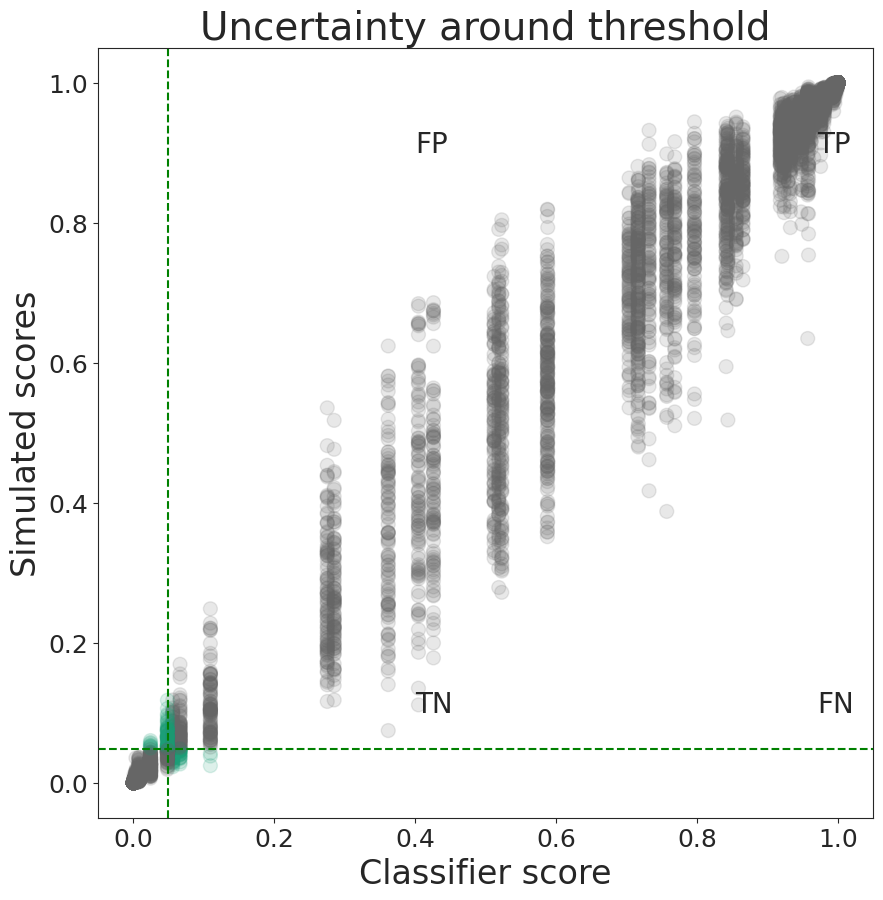

(63, 68, 105)

<Figure size 640x480 with 0 Axes>

In [15]:
plot_uncertainty_at_threshold(z_scores_df, coefficients, num_runs, uncertainty, thresh, num_patients)

#### Step 6: Accuracy Analysis: We are computing two things here:
#### 1: Accuracy- we are computing subject-wise accuracy by calculating number of simulations that fall in FP and FN for a subject at a given threshold. After calculating the total number of FN and FP, we subtract it with the total number of simulations, the resultant is then divided by the total number of simulations to provide us the accuracy for each subject. We perform this analysis for each %RSD which gives us a file of 243 subjects and their accuracies at each %RSD in the range.
#### 2: FP and FN- Here we calculate the total number of FP, FN, TP and TN across 243 subjects at a given %RSD. 

AD=np.int64(123) NCI=np.int64(120)


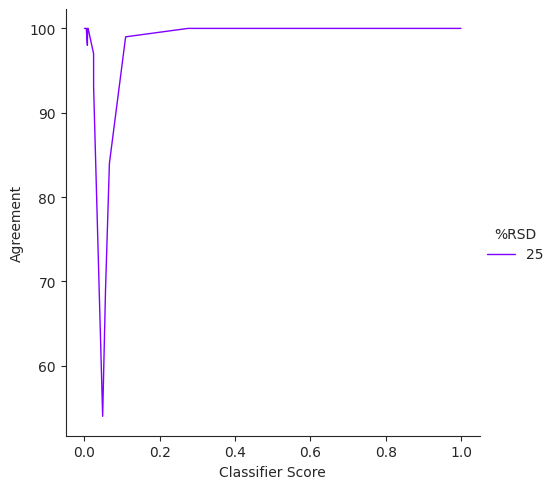

In [16]:
accuracy_df, false_pos_df = plot_v_plot(
    z_scores_df, coefficients, [25], thresh, 100
)

In [17]:
accuracy_df

,25,Classifier Score
Patient ID,,
11174,100.0,1.000000
11178,100.0,0.001538
11182,100.0,0.998083
11186,100.0,0.518584
11190,100.0,0.923664
...,...,...
5683,100.0,0.000143
5702,100.0,0.000526
5706,100.0,0.000669


In [18]:
disagreement_df = accuracy_df[accuracy_df[25] < 100]
disagreement_df = disagreement_df.sort_values(by=[25], ascending=False)
disagreement_df.shape

(7, 2)

In [19]:
disagreement_df.to_csv("subject-wise disagreement.csv")

In [20]:
false_pos_df

,25
simulations in agreement with subject,24194
simulations in disagreement with subject,106
Unreliable Subjects,7


In [21]:
accuracy_df

,25,Classifier Score
Patient ID,,
11174,100.0,1.000000
11178,100.0,0.001538
11182,100.0,0.998083
11186,100.0,0.518584
11190,100.0,0.923664
...,...,...
5683,100.0,0.000143
5702,100.0,0.000526
5706,100.0,0.000669


AD=np.int64(100) NCI=np.int64(143)
AD=np.int64(99) NCI=np.int64(144)
AD=np.int64(103) NCI=np.int64(140)


(               10     25     50  Classifier Score
 Patient ID                                       
 11174       100.0  100.0  100.0          1.000000
 11178       100.0  100.0  100.0          0.001564
 11182       100.0  100.0  100.0          0.998065
 11186       100.0   99.0   91.0          0.519430
 11190       100.0  100.0   91.0          0.923551
 ...           ...    ...    ...               ...
 5683        100.0  100.0  100.0          0.000146
 5702        100.0  100.0  100.0          0.000536
 5706        100.0  100.0  100.0          0.000682
 5767        100.0  100.0  100.0          0.000115
 5784        100.0  100.0  100.0          0.024556
 
 [243 rows x 4 columns],
                                              10     25     50
 simulations in agreement with subject     24218  24052  23734
 simulations in disagreement with subject     82    248    566
 Unreliable Subjects                           6     23     56)

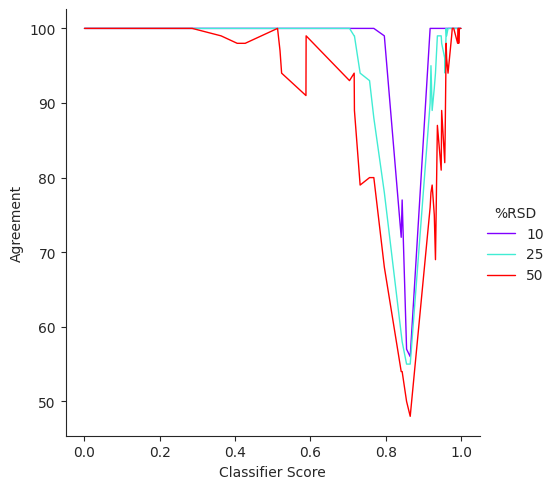

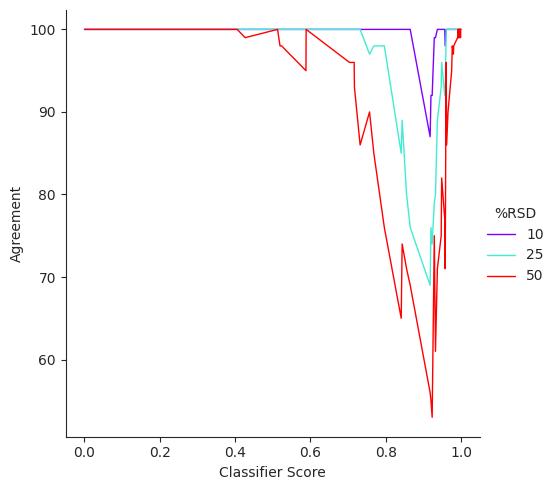

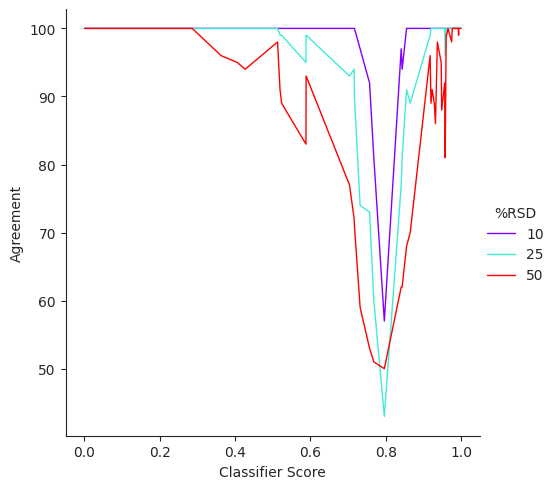

In [21]:
plot_v_plot(z_scores_df, coefficients, [10, 25, 50], 0.86, 100)
plot_v_plot(z_scores_df, coefficients, [10, 25, 50], 0.90, 100)
plot_v_plot(z_scores_df, coefficients, [10, 25, 50], 0.80, 100)

#### Output 2: accuracy file for each subject at each %RSD
ex: accuracy_df.to_csv("Subject accuracy at variations.csv")
#### Output 3: Datafile containing FP, FN, TP, TN from simulations for each %RSD
 ex: false_pos_df.to_csv("FP and FN analysis of simulations for %RSD.csv")
#### Output 4: v-plot fig of classifier scores vs agreement.